In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs-137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

21.8 +/- 1.9
19.3 +/- 1.6


/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/cosilab/miniconda3/lib/python3.11/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


# Do the same for the data after LL round 1

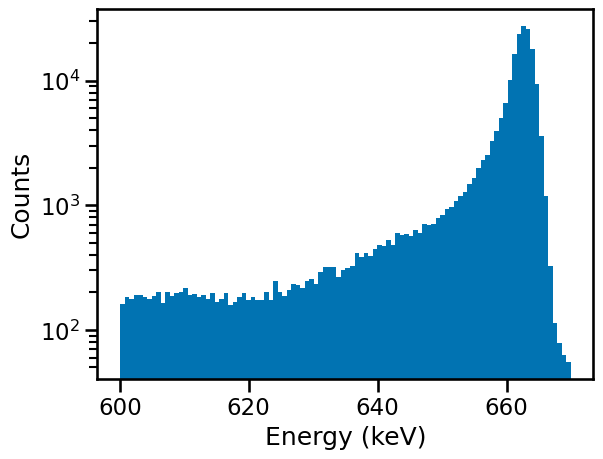

FWHM = 3.42
FWTM = 8.37


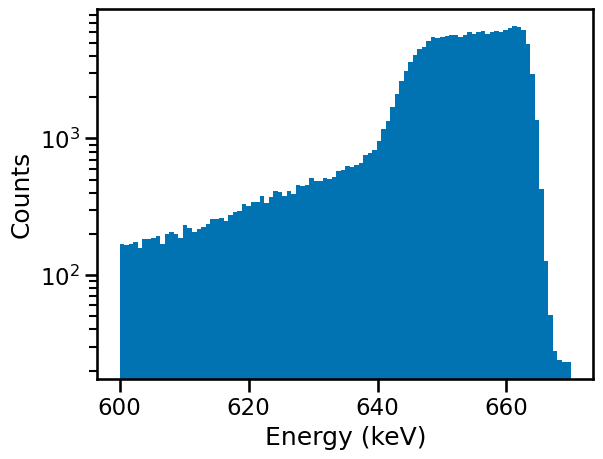

FWHM = 19.18
FWTM = 27.7


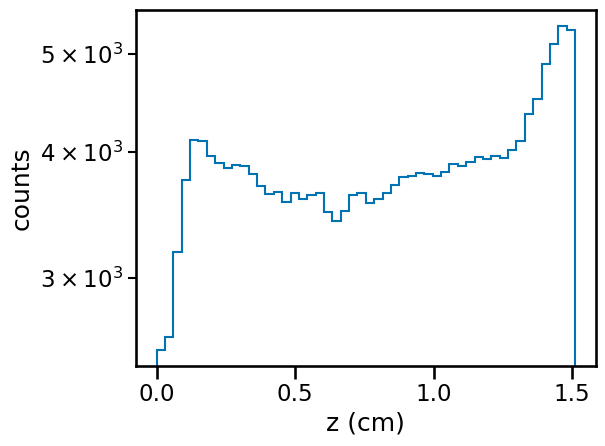

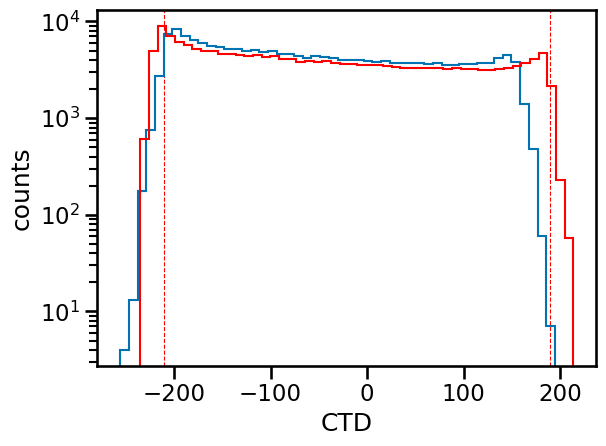

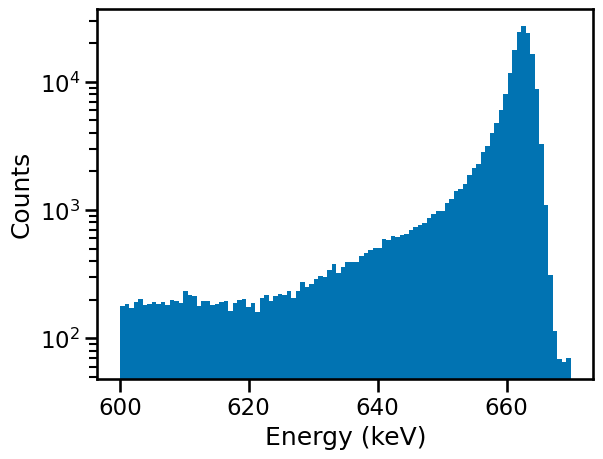

FWHM = 3.51
FWTM = 9.39


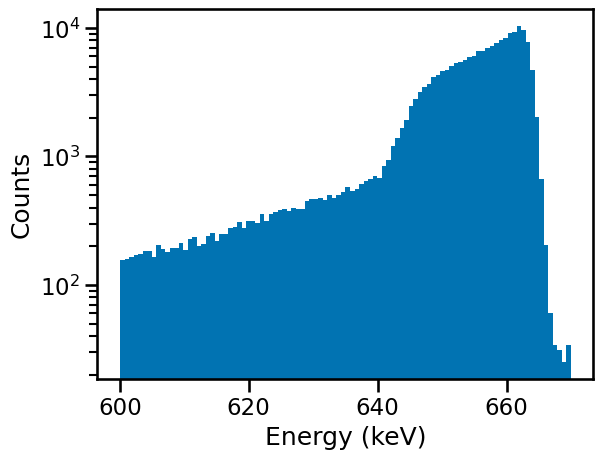

/home/cosilab/miniconda3/lib/python3.11/site-packages/scipy/interpolate/_fitpack2.py:313: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


FWHM = 12.31
FWTM = 23.26


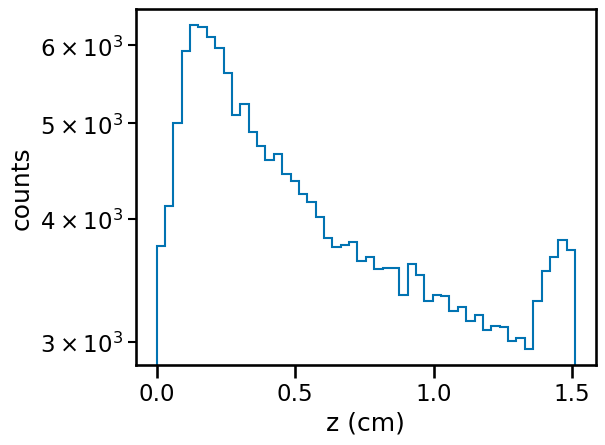

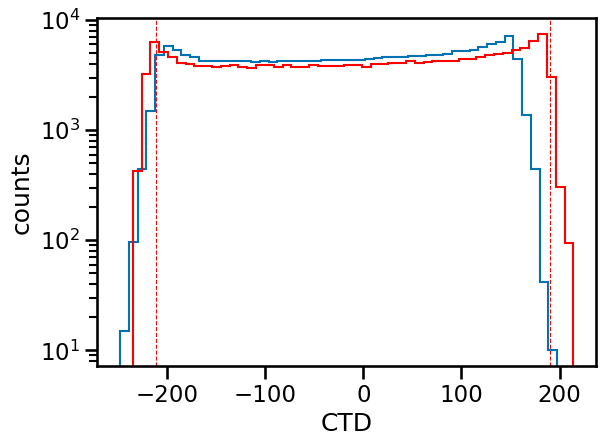

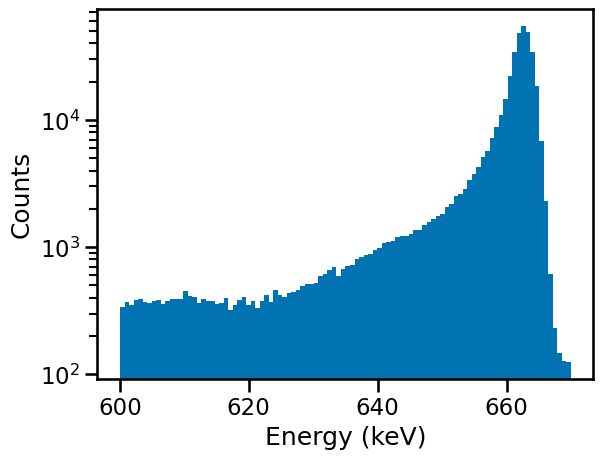

FWHM = 3.46
FWTM = 8.75


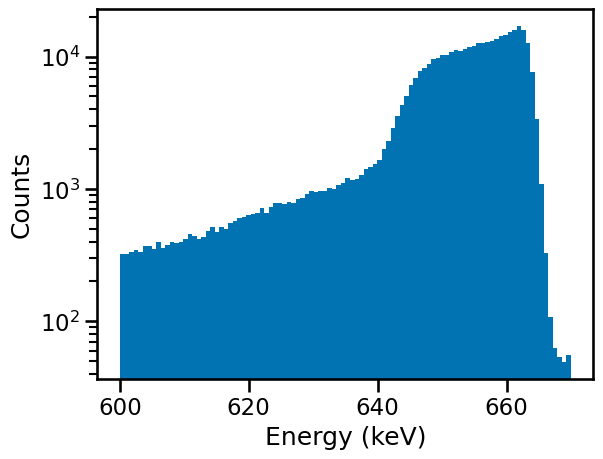

FWHM = 16.37
FWTM = 24.84


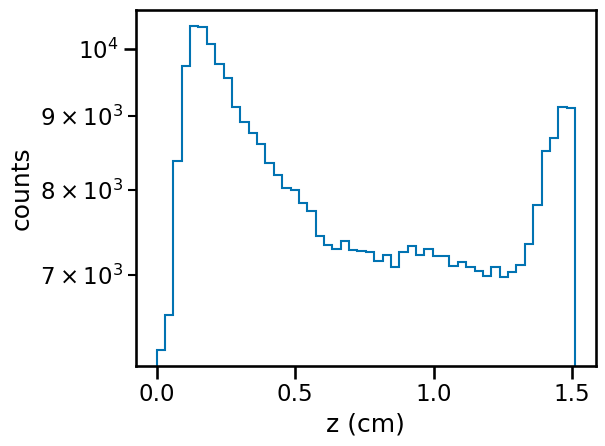

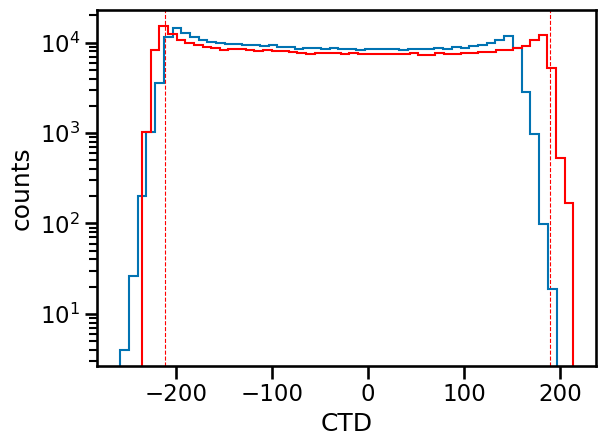

In [2]:
AC_list = ['20231030_Cs137_AC_600V.dat', '20231031_Cs137_AC_600V.dat', '20231101_Cs137_AC_600V.dat', '20231102_Cs137_AC_600V_1.dat', '20231102_Cs137_AC_600V_2.dat']
DC_list = ['20231030_Cs137_DC_600V_1.dat', '20231030_Cs137_DC_600V_2.dat', '20231031_Cs137_DC_600V.dat', '20231101_Cs137_DC_600V_1.dat', '20231101_Cs137_DC_600V_2.dat', '20231102_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postLL1', 'allDC_postLL1', 'allACandDC_postLL1']

emin = 600.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postLL1/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)
    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'bad'] =  bad

            ctd_obs_map[p][n] = ctd_obs[~bad]
            ctd_stretch_map[p][n] = ctd_stretch[~bad]
            ctd_obs_flat.append(ctd_obs[~bad])
            ctd_stretch_flat.append(ctd_stretch[~bad])

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'][~(df['bad'])], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'][~(df['bad'])], bins=binedges)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    
    plt.figure()
    plt.hist(df['z'][~(df['bad'])], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

df = df_list[-1]
z_list, e_signal_postLL1, h_signal_postLL1 = make_depthplot(df, strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [3]:
m = fit_CCE(z_list, [e_signal_postLL1[0], e_signal_postLL1[1]], [h_signal_postLL1[0], h_signal_postLL1[1]], sim_dCCE, plot_suffix = 'Cs137allACandDC_postLL1', trim=0.03)
print(m)

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 730.4 (chi2/ndof = 18.3)   │              Nfcn = 289              │
│ EDM = 7.16e-10 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──────

In [4]:
depth_correction(df, z_list, e_signal_postLL1, h_signal_postLL1, plot_suffix = 'Cs137allACandDC_postLL1')

FWHM = 3.47
FWTM = 8.77
FWHM = 3.34
FWTM = 8.54
FWHM = 19.48
FWTM = 0.0
FWHM = 12.31
FWTM = 18.79


,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z,z_err,bad,z_binned,depth_corrected_energy_p,depth_corrected_energy_n
0,5,11,29,634.707619,165.0,30,651.024903,270.0,1.634266e+307,1.634266e+307,1.019637,0.046272,False,"(1.007, 1.057]",633.260428,660.415419
1,226,11,26,645.811275,195.0,31,658.296893,185.0,1.634266e+307,1.634266e+307,0.516903,0.039118,False,"(0.503, 0.554]",644.878745,661.573165
2,237,11,29,661.685139,210.0,21,655.784919,140.0,1.634266e+307,1.634266e+307,0.375470,0.035870,False,"(0.352, 0.403]",661.015665,657.571075
3,242,11,36,663.903327,195.0,22,656.770645,185.0,1.634266e+307,1.634266e+307,0.578499,0.039306,False,"(0.554, 0.604]",662.830844,660.700137
4,267,11,3,658.637600,140.0,22,651.787015,335.0,1.634266e+307,1.634266e+307,1.325537,0.064006,False,"(1.309, 1.359]",657.441262,666.531837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399050,2841218,11,4,638.677239,355.0,25,571.855481,0.0,1.634266e+307,1.634266e+307,0.029289,0.013004,True,"(0.0, 0.0503]",638.740649,570.166177
399051,2841420,11,1,642.093556,210.0,32,83.610257,0.0,1.634266e+307,1.634266e+307,0.065197,0.017667,True,"(0.0503, 0.101]",642.087110,83.415629
399052,2841586,11,6,639.096258,245.0,32,515.441361,0.0,1.634266e+307,1.634266e+307,0.001155,0.014996,True,"(0.0, 0.0503]",639.213029,513.660866
399053,2841687,11,12,647.530503,175.0,32,101.928716,0.0,1.634266e+307,1.634266e+307,0.012397,0.022718,True,"(0.0, 0.0503]",647.627393,101.597104


/home/cosilab/COSITrapping/depth_helpers.py:324: RuntimeWarning: invalid value encountered in scalar divide
  mean_depth = np.sum(prob_dist*self.sim_depth)/np.sum(prob_dist)
/home/cosilab/COSITrapping/depth_helpers.py:330: RuntimeWarning: invalid value encountered in divide
  prob_dist = prob_dist/prob_norm


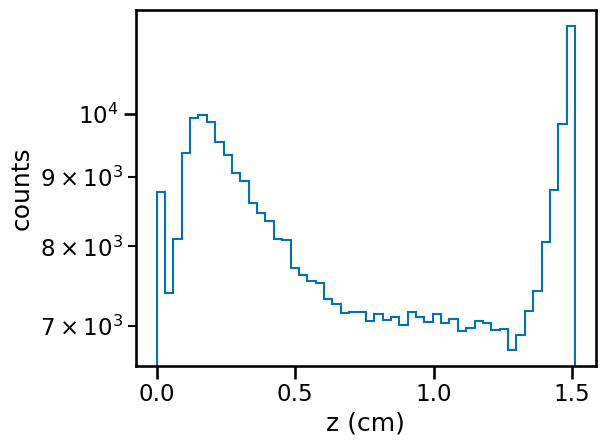

In [5]:
for p in range(37):
    for n in range(37):
        ctd_obs, ctd_stretch, depth, depth_err, bad = calibrator.depth_from_timing_and_energy(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                   df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                  df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'], \
                                                                                              df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_n'], \
                                                                                             sim_dCCE, m.values['ae']/m.values['ah'], m.values['b'], m.values['c'])
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
        df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err

plt.figure()
plt.hist(df['z'][~(df['bad'])], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
plt.yscale('log')
plt.xlabel("z (cm)")
plt.ylabel("counts")
plt.tight_layout()
plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_energy.pdf')

z_list, e_signal_postLL1, h_signal_postLL1 = make_depthplot(df, 'allACandDC_postLL1_energydepthcal', zmin=calibrator.zmin, zmax=calibrator.zmax)

In [6]:
depth_correction(df, z_list, e_signal_postLL1, h_signal_postLL1, plot_suffix = 'Cs137allACandDC_postLL1_energydepthcal')

FWHM = 3.47
FWTM = 8.77
FWHM = 3.36
FWTM = 8.49
FWHM = 19.48
FWTM = 0.0
FWHM = 4.16
FWTM = 9.36


,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z,z_err,bad,z_binned,depth_corrected_energy_p,depth_corrected_energy_n
0,5,11,29,634.707619,165.0,30,651.024903,270.0,1.634266e+307,1.634266e+307,0.946927,0.043748,False,"(0.906, 0.956]",633.289976,659.485483
1,226,11,26,645.811275,195.0,31,658.296893,185.0,1.634266e+307,1.634266e+307,0.475397,0.036407,False,"(0.453, 0.503]",644.973088,661.193820
2,237,11,29,661.685139,210.0,21,655.784919,140.0,1.634266e+307,1.634266e+307,0.429740,0.035621,False,"(0.403, 0.453]",660.919759,658.182205
3,242,11,36,663.903327,195.0,22,656.770645,185.0,1.634266e+307,1.634266e+307,0.538609,0.038483,False,"(0.503, 0.554]",662.918781,660.348417
4,267,11,3,658.637600,140.0,22,651.787015,335.0,1.634266e+307,1.634266e+307,1.249471,0.054020,False,"(1.208, 1.258]",657.298437,664.876553
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399050,2841218,11,4,638.677239,355.0,25,571.855481,0.0,1.634266e+307,1.634266e+307,0.048241,0.011919,True,"(0.0, 0.0503]",638.768826,570.435803
399051,2841420,11,1,642.093556,210.0,32,83.610257,0.0,1.634266e+307,1.634266e+307,NaN,NaN,True,NaN,NaN,NaN
399052,2841586,11,6,639.096258,245.0,32,515.441361,0.0,1.634266e+307,1.634266e+307,NaN,NaN,True,NaN,NaN,NaN
399053,2841687,11,12,647.530503,175.0,32,101.928716,0.0,1.634266e+307,1.634266e+307,NaN,NaN,True,NaN,NaN,NaN
